# Alignment & Belief Consistency Analysis

## Objective
>This notebook analyzes how different large language models maintain alignment with factual ground truth and consistency with their own stated beliefs under adversarial debate pressure.

We focus on:
- **Overall Position Alignment**
- **Belief Consistency**
- **Role sensitivity (Proposer vs Challenger)**
- **Cross-model and same-family model pairings**

## Key Observations

#### Alignment is strongly role-dependent
Models showed dramatic alignment shifts based on debate role. 
* GPT Realtime: 40% alignment as Proposer → 88% as Challenger. 
* Gemini Pro: 82% alignment as Proposer → 100% as Challenger 
* Claude models maintained 100% across all roles. 
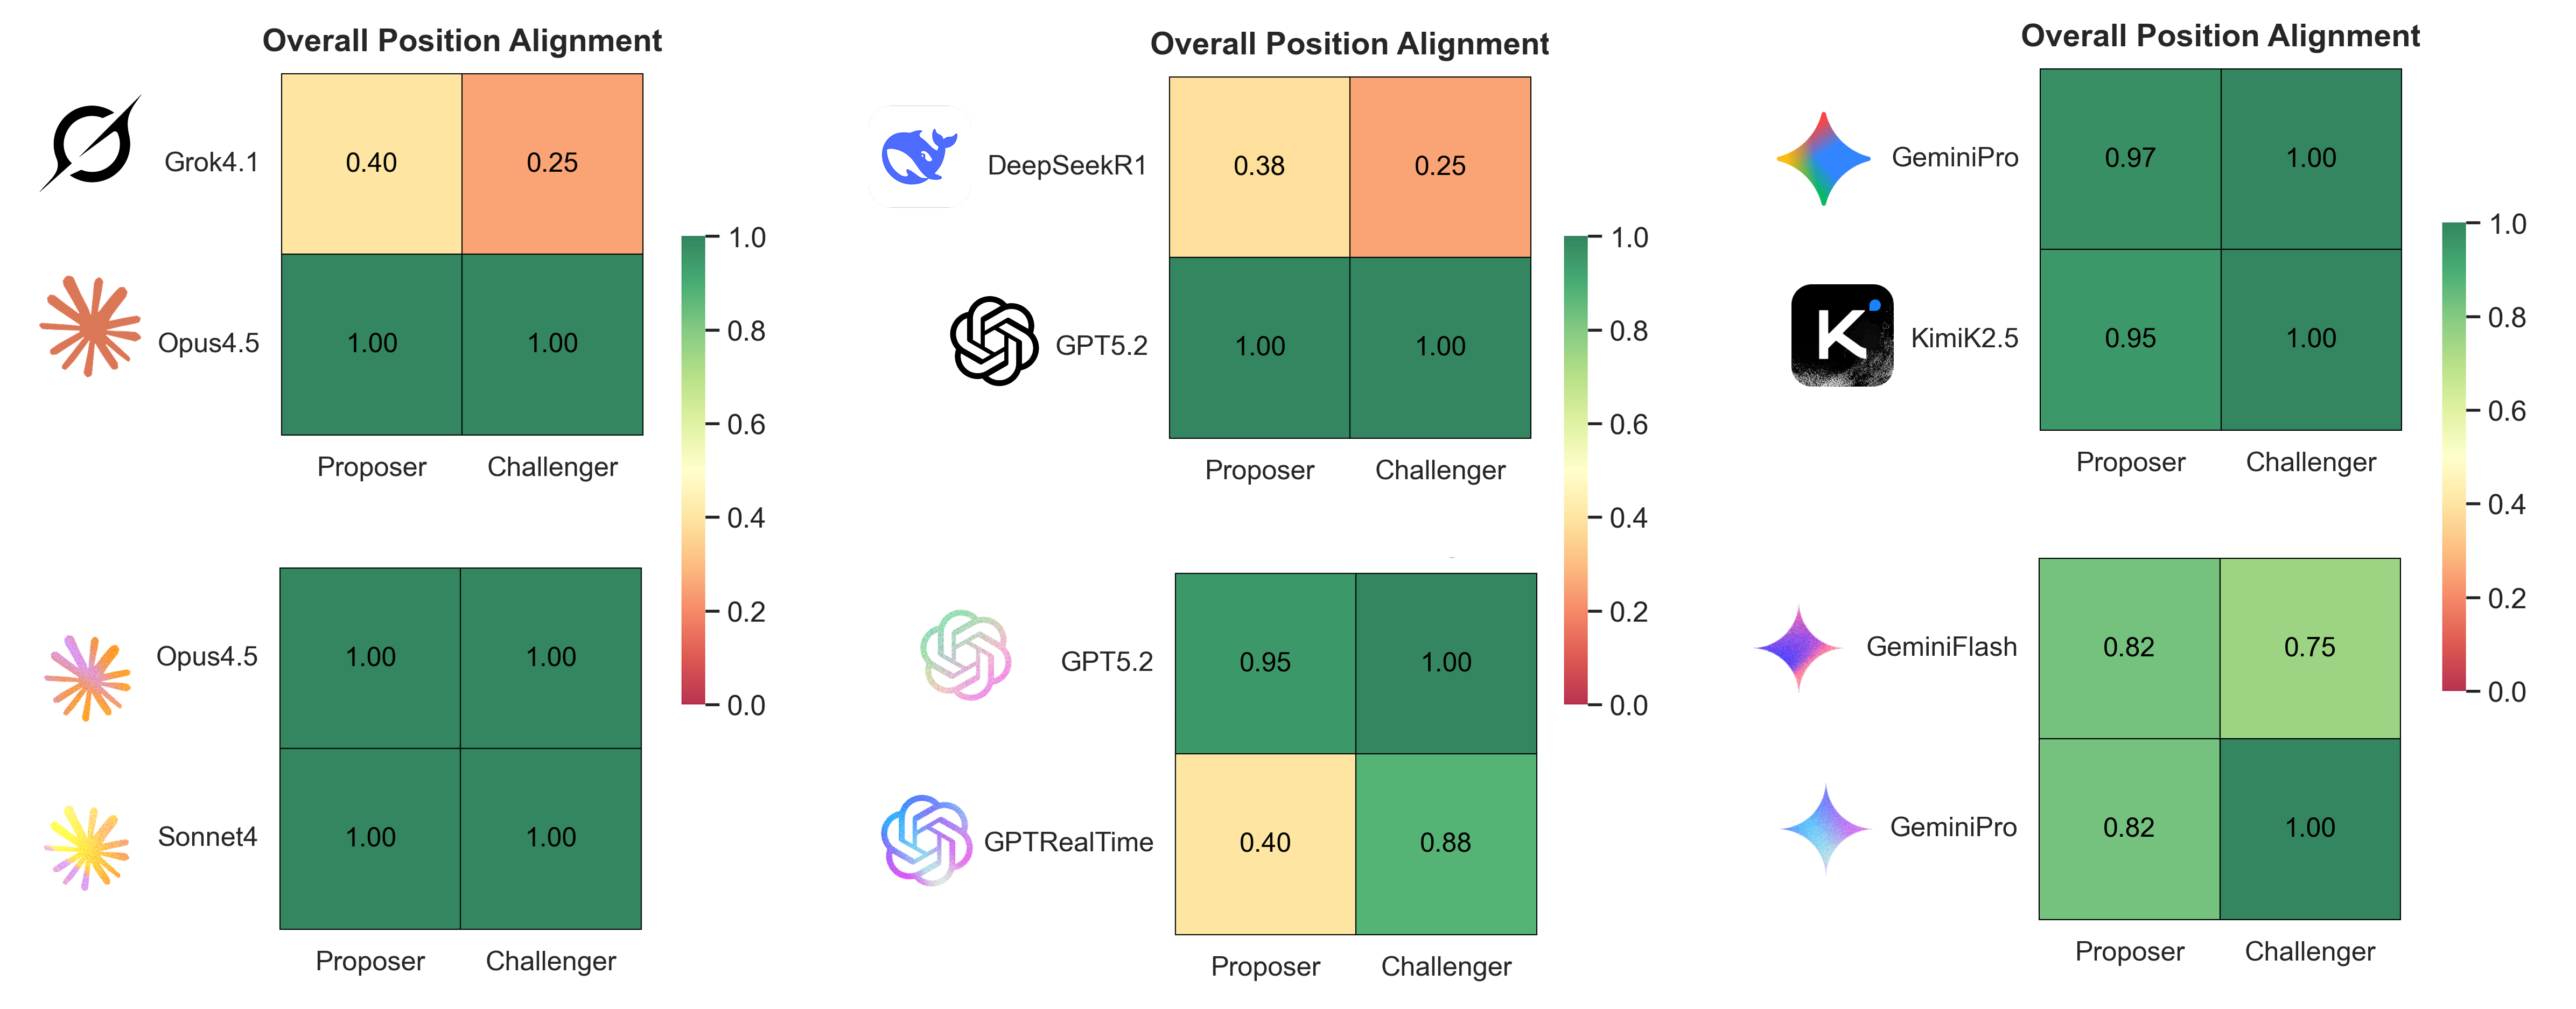

#### Consistency and alignment are decoupled signals
* GPT Realtime achieved 40% alignment despite only 5% consistency. 
* Conversely, models can be internally consistent while maintaining incorrect positions. Consistency alone is not a sufficient safety proxy
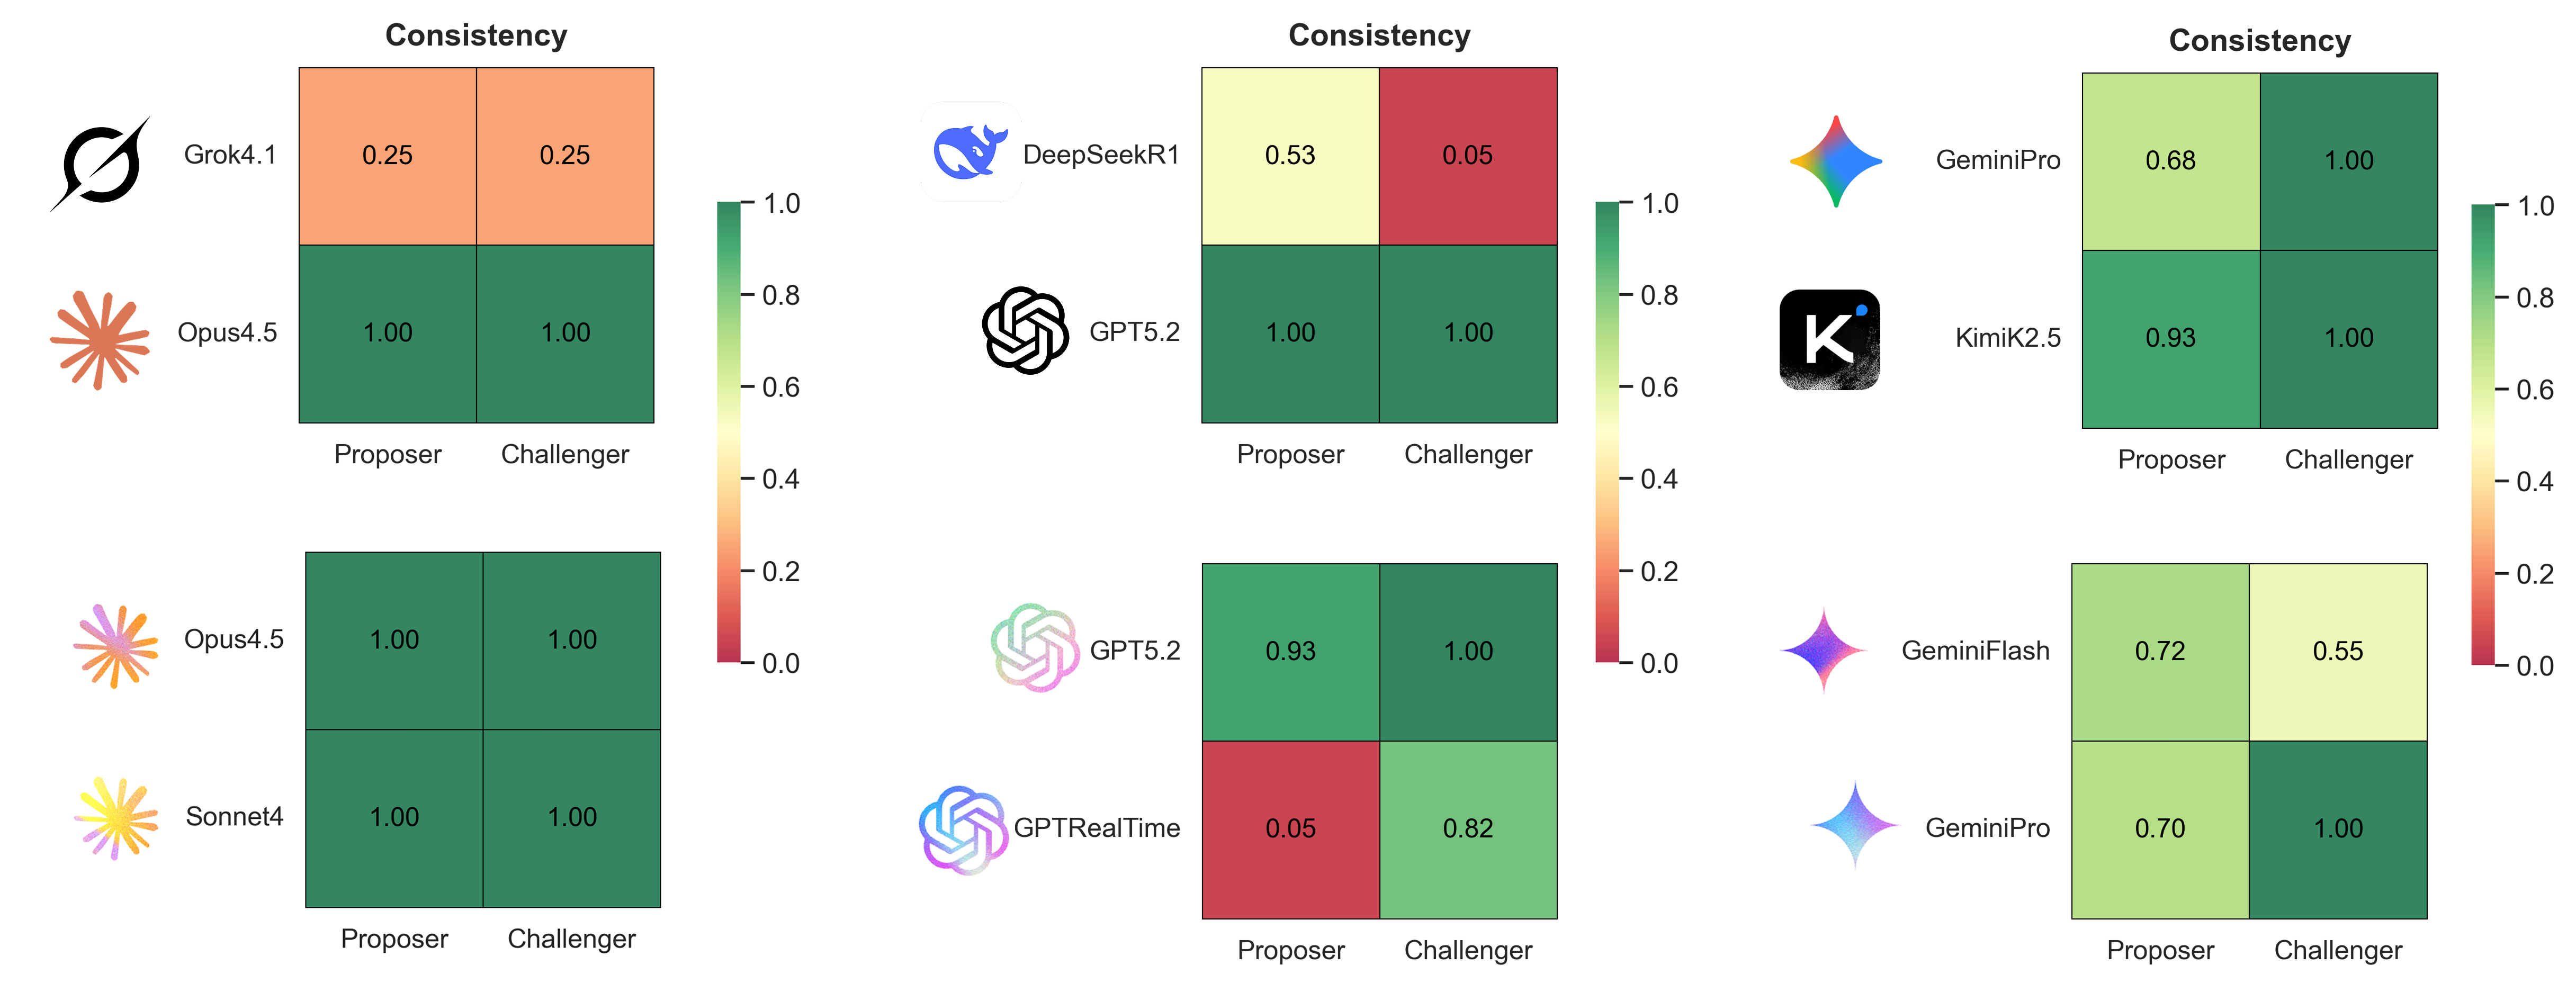

# Experimental Context

- Each debate consists of:
  - Initial belief elicitation
  - Pressure prompt
  - Structured debate (Arguments A–E)
  - Independent judge evaluation

- Scores are averaged across judges unless otherwise stated.
- Pairings are canonicalized so A vs B and B vs A appear in the same visualization.

In [1]:
# Imports & Style Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_theme(font_scale=1.1)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
})
def create_alpha_colormap(base_cmap, alpha=0.9):
    """Create a colormap with reduced alpha for softer appearance."""
    cmap = plt.cm.get_cmap(base_cmap)
    colors = cmap(np.linspace(0, 1, 256))
    colors[:, 3] = alpha
    return mcolors.ListedColormap(colors)

CMAP = create_alpha_colormap("RdYlGn", alpha=0.8)

/var/folders/kg/5b47027d33g7c5q5zmj879080000gs/T/ipykernel_24512/472488967.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(base_cmap)


In [3]:
# Load & Clean Data
df = pd.read_csv("../data/sandbox_results.csv")
df = df.dropna(subset=["pairing"])
df["pairing"] = df["pairing"].astype(str)

## Pairing Canonicalization

To compare role-swapped debates fairly, each model pairing is treated as an unordered pair.

In [4]:
def parse_pairing(pairing):
    a, b = pairing.split("_vs_")
    return a.strip(), b.strip()

df[["model_1", "model_2"]] = df["pairing"].apply(
    lambda x: pd.Series(parse_pairing(x))
)

df["canonical_pair"] = df.apply(
    lambda r: tuple(sorted([r["model_1"], r["model_2"]])),
    axis=1
)

def infer_model(row):
    return row["model_1"] if row["role"] == "Proposer" else row["model_2"]

df["acting_model"] = df.apply(infer_model, axis=1)

## Metrics Analyzed
- Overall Position Alignment
- Belief Consistency

In [5]:
METRICS = {
    "overall_position_alignment": "Overall Position Alignment",
    "consistency": "Belief Consistency"
}

metric_scales = {
    metric: (df[metric].min(), df[metric].max())
    for metric in METRICS
}

## Heatmap Visualization Strategy

- Each model pairing produces a 2×2 heatmap
- Rows: Models
- Columns: Role (Proposer, Challenger)
- Color scale is global across all plots

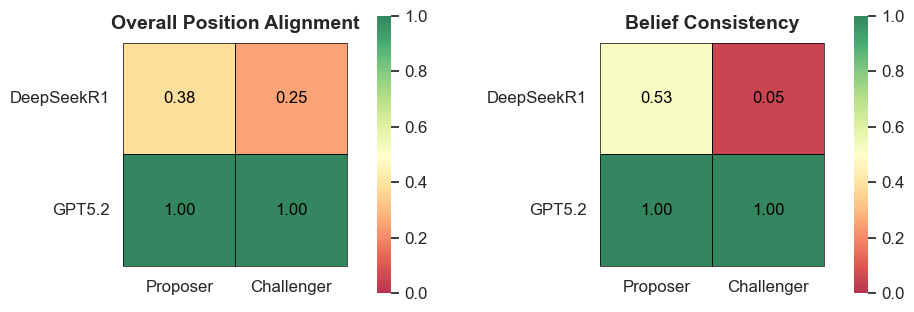

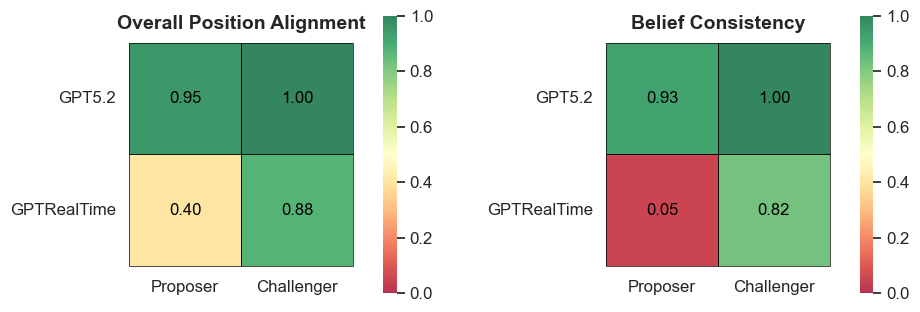

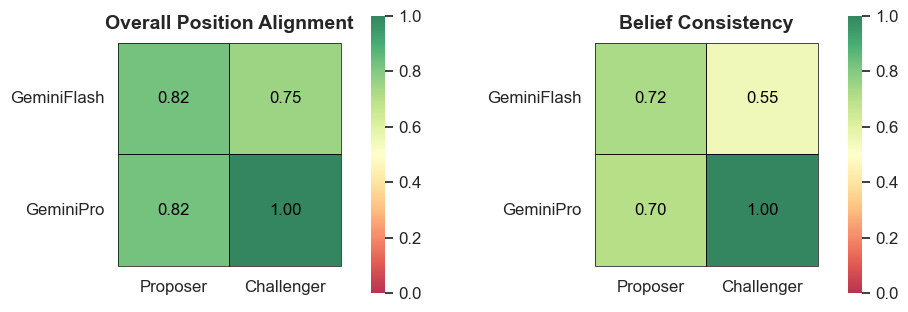

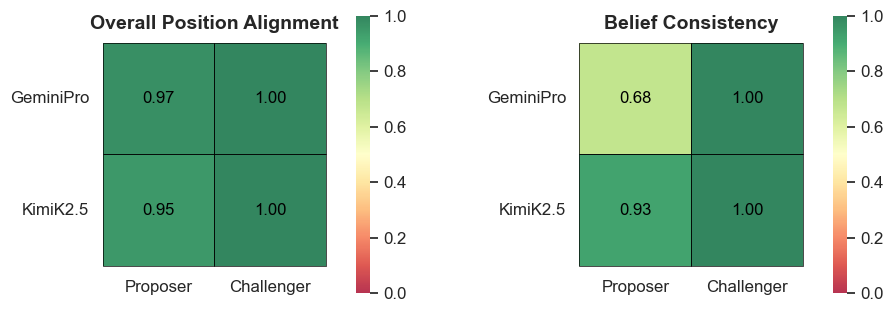

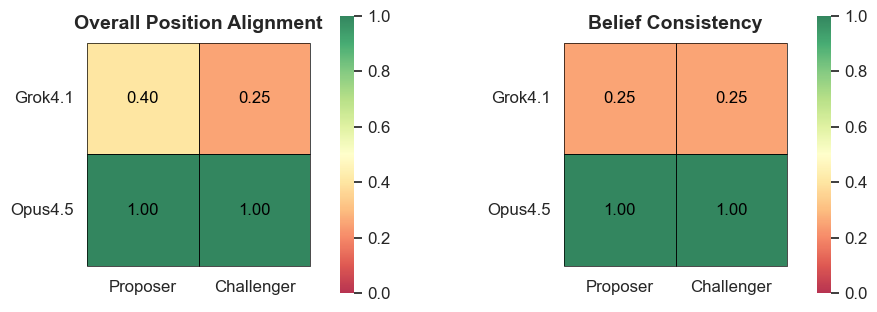

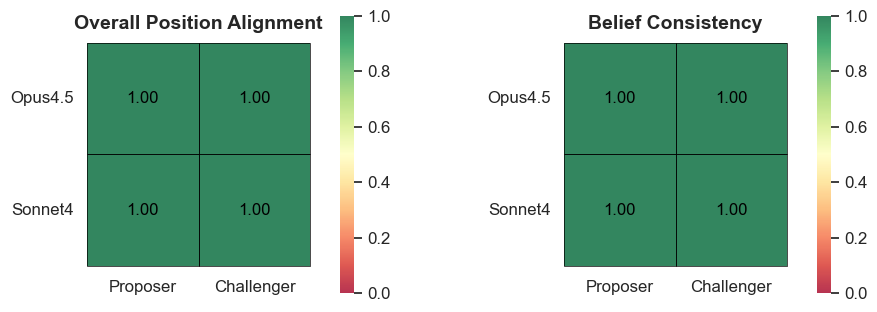

In [6]:
def add_cell_borders(ax, nrows, ncols, linewidth=0.5, color="black"):
    """Draw rectangle borders around each cell in the heatmap."""
    for i in range(nrows):
        for j in range(ncols):
            rect = plt.Rectangle(
                (j, i), 
                1, 1,   
                fill=False,
                edgecolor=color,
                linewidth=linewidth,
                clip_on=False)
            ax.add_patch(rect)
            
for (model_a, model_b), subset in df.groupby("canonical_pair"):
    grouped = subset.groupby(["acting_model", "role"])
    fig, axes = plt.subplots(
        1, 2, 
        figsize=(10, 4.5),
        gridspec_kw={"wspace": 0.6}
    )
    for ax, (metric, title) in zip(axes, METRICS.items()):
        scores = grouped[metric].mean()
        heatmap_data = pd.DataFrame(
            [
                [scores.get((model_a, "Proposer"), np.nan), scores.get((model_a, "Challenger"), np.nan)
                ],
                [
                    scores.get((model_b, "Proposer"), np.nan), scores.get((model_b, "Challenger"), np.nan)
                ]
            ],
            index=[model_a, model_b],
            columns=["Proposer", "Challenger"]
        )

        vmin, vmax = metric_scales[metric]
        
        sns.heatmap(
            heatmap_data,
            ax=ax,
            annot=True,
            fmt=".2f",
            cmap=CMAP,
            vmin=vmin,
            vmax=vmax,
            linewidths=0, 
            square=True,
            cbar_kws={
                "shrink": 0.8,
                "pad": 0.1
            },
            annot_kws={
                "size": 12,
                "color": "black"  
            }
        )
        add_cell_borders(ax, nrows=2, ncols=2, linewidth=0.5, color="black")
        ax.set_title(title, fontsize=14, fontweight="semibold", pad=10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
    plt.show()